# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
#!pip install phik
#!pip install scikit-learn==1.1.3
#!pip install category_encoders
#!pip install shap

In [2]:
import math
import time
import os
import phik
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    KFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from sklearn.base import clone


## Подготовка данных

### Загрузка данных

In [3]:
df = pd.read_csv('/datasets/autos.csv')
pth1 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
else:
    print('Something is wrong_1')
    

In [4]:
display(df.sample(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
156902,2016-03-10 09:49:46,1700,small,2004,manual,64,polo,150000,7,petrol,volkswagen,no,2016-03-10 00:00:00,0,45139,2016-03-17 11:46:30
178997,2016-04-01 14:57:26,3200,coupe,2002,manual,0,cooper,150000,8,petrol,mini,no,2016-04-01 00:00:00,0,63739,2016-04-07 12:46:26
38207,2016-03-17 18:57:18,16999,convertible,2008,auto,163,slk,40000,2,petrol,mercedes_benz,no,2016-03-17 00:00:00,0,40468,2016-04-07 06:16:53
107196,2016-03-14 09:37:19,1650,NaN,2017,manual,110,golf,150000,0,gasoline,volkswagen,NaN,2016-03-14 00:00:00,0,84095,2016-04-07 08:16:19
268803,2016-03-07 21:55:32,6500,wagon,2007,manual,105,passat,150000,4,gasoline,volkswagen,NaN,2016-03-07 00:00:00,0,17213,2016-03-28 09:46:21
352891,2016-03-20 10:59:18,9350,sedan,2011,manual,95,a_klasse,40000,11,petrol,mercedes_benz,no,2016-03-20 00:00:00,0,12627,2016-03-31 16:15:45
123617,2016-04-03 11:55:40,1100,sedan,1998,manual,125,a4,150000,11,petrol,audi,NaN,2016-04-03 00:00:00,0,13583,2016-04-05 10:18:28
175789,2016-03-30 13:50:51,13500,wagon,2009,manual,160,a3,70000,10,petrol,audi,no,2016-03-30 00:00:00,0,58095,2016-04-07 04:44:50
179762,2016-03-10 19:57:04,7150,sedan,2007,manual,231,3er,150000,7,gasoline,bmw,no,2016-03-10 00:00:00,0,80636,2016-04-06 04:15:31
45387,2016-03-22 11:47:46,6099,small,2009,manual,95,other,125000,1,petrol,alfa_romeo,no,2016-03-22 00:00:00,0,30165,2016-04-06 00:15:46


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
base_len = len(df)

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных есть пропуски и ошибки. Названия столбцов надо привести к принятому виду. Всего 354369 строк.

### Предобработка данных

Столбцы с датами выглядят неинформативно. Их можно удалить.

In [8]:
df = df.drop('DateCrawled', axis=1)
df = df.drop('DateCreated', axis=1)
df = df.drop('LastSeen', axis=1)

Изменим название столбцов:

In [9]:
df.columns = df.columns.str.lower()

In [10]:
df.columns = (
    df.columns.str.replace('registrationyear', 'registration_year')
              .str.replace('vehicletype','vehicle_type')
              .str.replace('registrationmonth','registration_month')
              .str.replace('fueltype','fuel_type')
              .str.replace('numberofpictures','number_of_pictures')
              .str.replace('postalcode','postal_code')
              )

Проверим дубликаты:

In [11]:
display(df.duplicated().sum())

21333

21333 полных дубликата. Удалим их:

In [12]:
df = df.drop_duplicates()

In [13]:
display(df[['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired']].duplicated().sum())

6210

Без столбцов `number_of_pictures` и `postal_code` еще 6210 повторов. Вряд ли это совпадение.

In [14]:
df = df.drop_duplicates(subset=['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
    'model', 'kilometer', 'registration_month', 'fuel_type', 'brand','repaired'])

Удалим столбцы `number_of_pictures` и `postal_code`:

In [15]:
df = df.drop('number_of_pictures', axis=1)
df = df.drop('postal_code', axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326826 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326826 non-null  int64 
 1   vehicle_type        291577 non-null  object
 2   registration_year   326826 non-null  int64 
 3   gearbox             309248 non-null  object
 4   power               326826 non-null  int64 
 5   model               308294 non-null  object
 6   kilometer           326826 non-null  int64 
 7   registration_month  326826 non-null  int64 
 8   fuel_type           295704 non-null  object
 9   brand               326826 non-null  object
 10  repaired            260399 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB


Пропуски:

In [17]:
def uniques(df):
    for col in df.select_dtypes(exclude='number').columns.tolist():
        unique_values = df[col].unique()
        print(f"Уникальные значения в столбце '{col}': {unique_values}")

In [18]:
uniques(df)

Уникальные значения в столбце 'vehicle_type': [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения в столбце 'gearbox': ['manual' 'auto' nan]
Уникальные значения в столбце 'model': ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' '

Поскольку в некоторых местах пропусков примерно 20% от общих данных, а также есть аномальные значения, устранять все это надо аккуратно, для того, чтобы сохранить как можно больше данных. Сначала надо удалить очевидные пропуски и аномалии, с которыми делать больше нечего:

*petrol* и *gasoline* - это одно и то же (но странно, что нет дизеля). Исправим:

In [19]:
df['fuel_type'] = df['fuel_type'].replace({'gasoline': 'petrol'})

Пропуски в столбце `model` никаким разумным способом нельзя заполнить правильно. Удаляем:

In [20]:
df = df.dropna(subset=['model'])

`price` - целевой признак. Удаляем слишком маленькие значения:

In [21]:
df = df.query('price > 50')

Удалим несколько аномально высоких строк из признака `power`:

In [22]:
df = df.query('power < 570')

Удалим несколько аномально высоких и низких значений из признака `registration_year`:

In [23]:
df = df.query('registration_year < 2016')

In [24]:
df = df.query('registration_year > 1970')

Теперь, когда в `model` и `brand` нет пропусков можно устранить другие пропуски:
Сгруппируем `model` и `brand`, найдем моду и заполним ей пропуски в `vehicle_type`:

In [25]:
#transform('mode') не работает вроде как по причине того, что некоторые группировки выдают Series из моды из-за одинакового
#некоторых вариантов. Поэтому используем lamba функцию, где можно явно указать, что надо брать элемент с нулевым индексом.
df['gearbox'] = df['gearbox'].fillna(df.groupby(['brand', 'model'])['gearbox']
      .transform(lambda x: x.mode().iloc[0])
)

In [26]:
df['fuel_type'] = df['fuel_type'].fillna(df.groupby(['brand', 'model','gearbox'])['fuel_type']
      .transform(lambda x: x.mode().iloc[0])
)

In [27]:
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby(['brand', 'model'])['vehicle_type']
      .transform(lambda x: x.mode().iloc[0])
)

Такую группировку я делаю из-за того, что заполняемые значения с большой вероятностью зависят только от сгруппированных признаков. (можно было бы еще смотреть по году регистрации и сравнивать с годами выпуска, но это опять же неразумно). Признак `repaired` я заполню в *SimpleImputer*, поскольку он будет учитывать все признаки, например, год регистрации и цену, что повысит вероятность заполнить эти пропуски правильно.

С другой стороны складывается ощущение, что целевым признаком надо делать `repaired` и обучать модель определять был ли ремонт...

Разберемся с `power` = 0

In [28]:
df['engine_status'] = np.where(df['power'] == 0, 'без двигателя', 'с двигателем')

In [29]:
df.groupby(['engine_status'])['price'].median()

engine_status
без двигателя    1300
с двигателем     3299
Name: price, dtype: int64

Создадим категории для машин:

In [30]:
df['oldness'] = np.where(df['registration_year'] < 1980, 
                                   'Ретро', np.where(df['registration_year'] < 2000, 'Старая', 'Новая'))

In [31]:
print(f'Осталось {len(df)} строк')
print(f'Удалено {base_len - len(df)} строк')
print(f'Удалено {((base_len - len(df))/base_len)*100:.2f}% изначальных строк') 

Осталось 279265 строк
Удалено 75104 строк
Удалено 21.19% изначальных строк


Осталось 297869 строк
Удалено 56500 строк
Удалено 15.94% изначальных строк. 

Обработаны пропуски в столбцах `vehicle_type`, `gearbox`, `fuel_type`. Устранены выбросы в некоторых числовых признаках.

### Исследовательский анализ данных

Построим гистограммы с ядерной плотностью для числовых признаков:

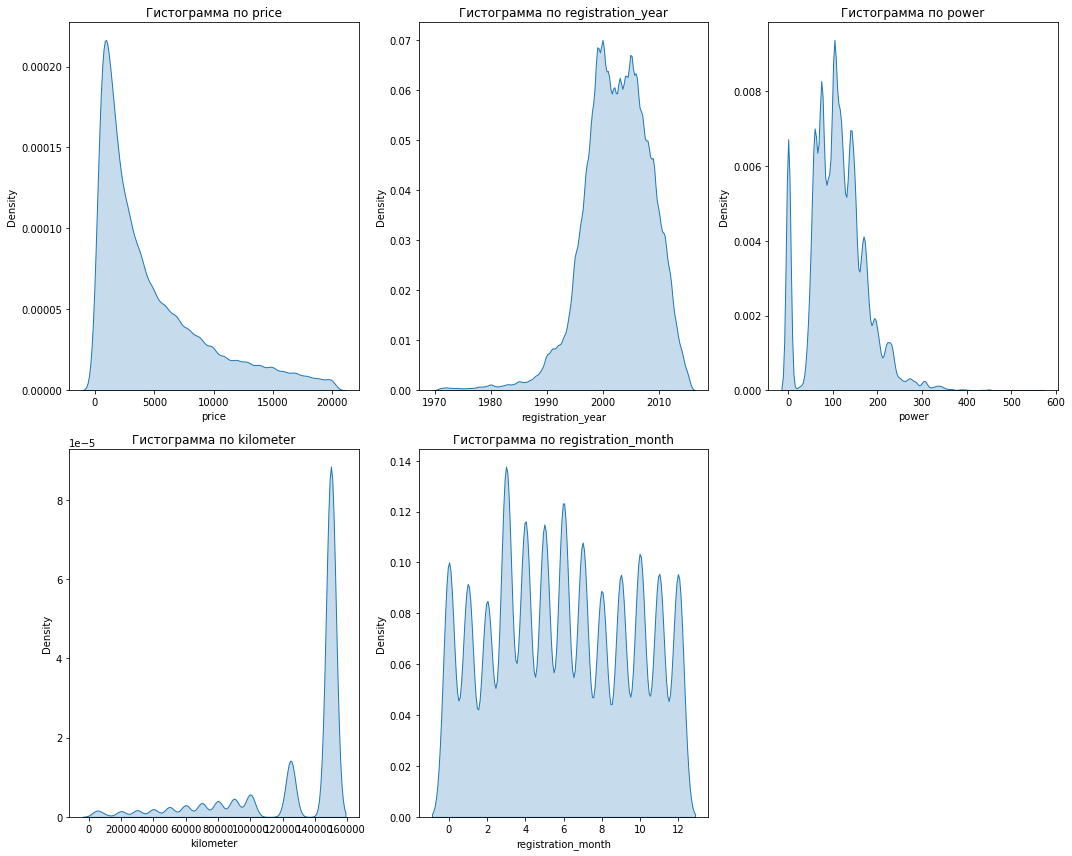

In [32]:
num_cols = df.select_dtypes(include='number').columns.tolist()

n = len(num_cols)
n_cols = 3
n_rows = math.ceil(n/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols*5, n_rows*6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
    axes[i].set_title(f'Гистограмма по {col}')
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. 

Боксплоты:

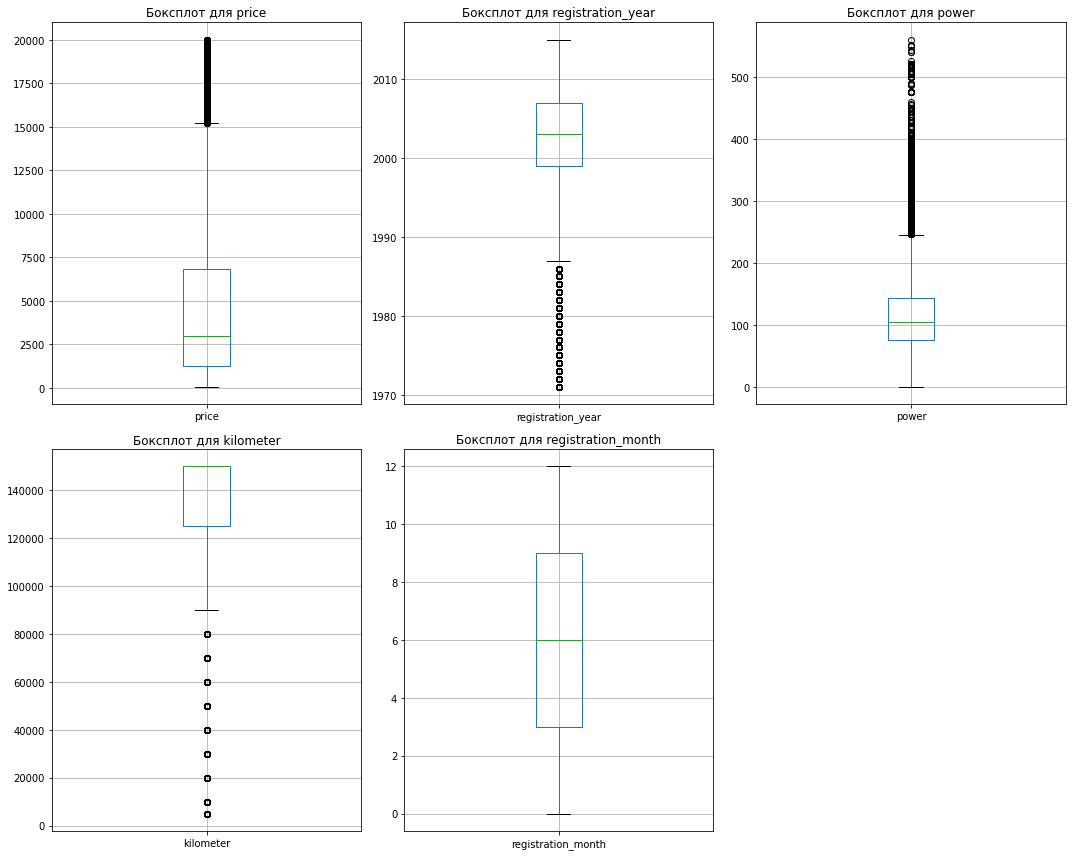

In [33]:
num_cols = df.select_dtypes(include='number').columns.tolist()

n = len(num_cols)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Боксплот для {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. `price` - много выбросов по верхней границе. Медиана около 2500. Скорее всего люксовые машины.
2. `registration_year` - есть группа очень старых машин.
3. `kilometer` - значения в основном близки к 125 000–150 000. Есть группа относительно новых машин.
4. `registration_month` - без сюрпризов. Признак можно удалить как бесполезный

Анализ категориальных признаков:

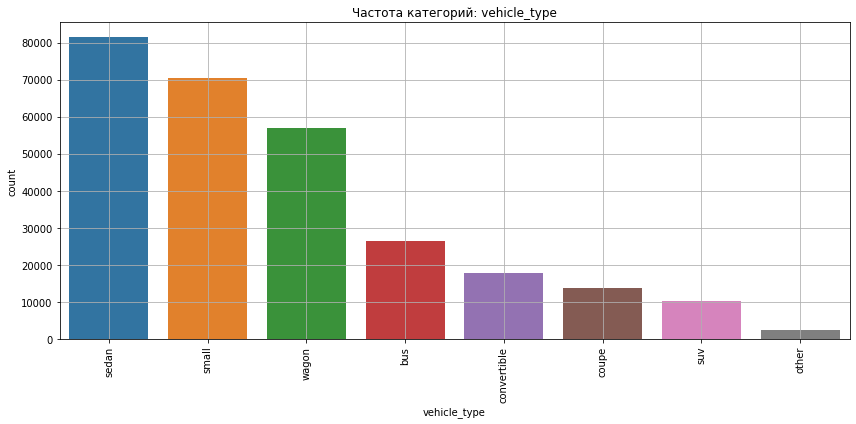

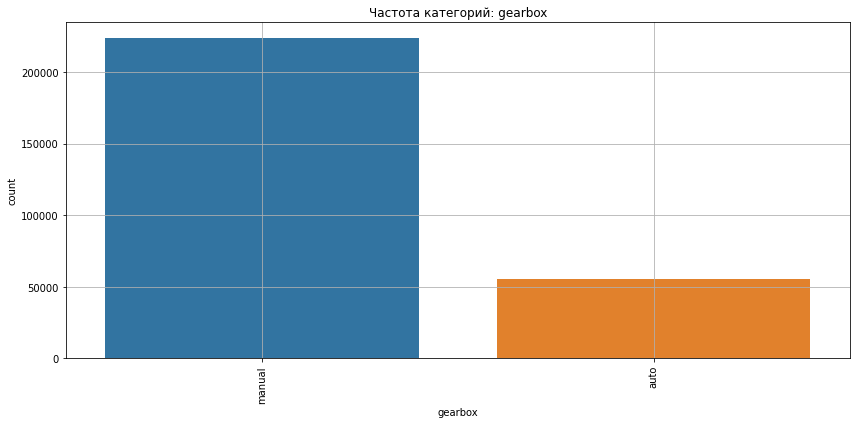

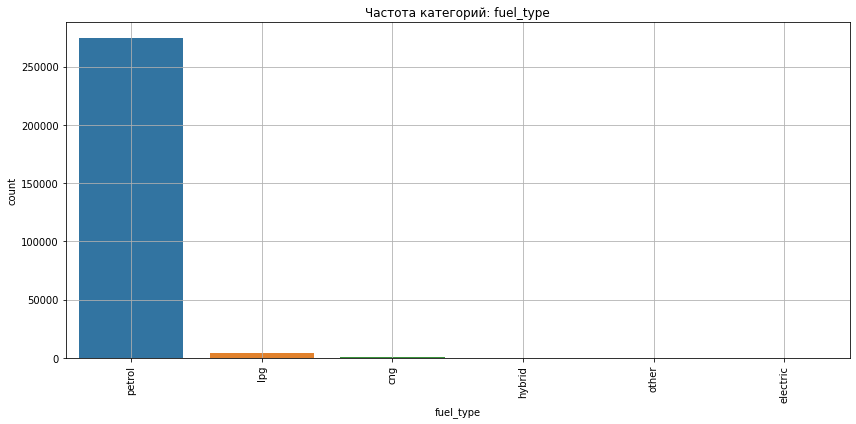

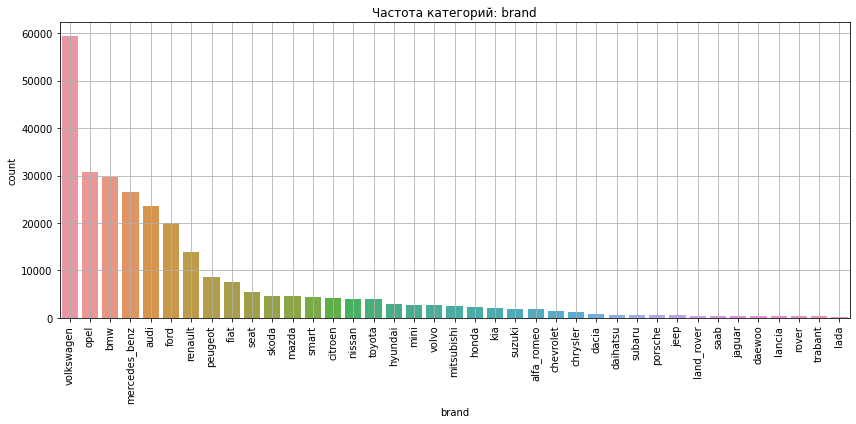

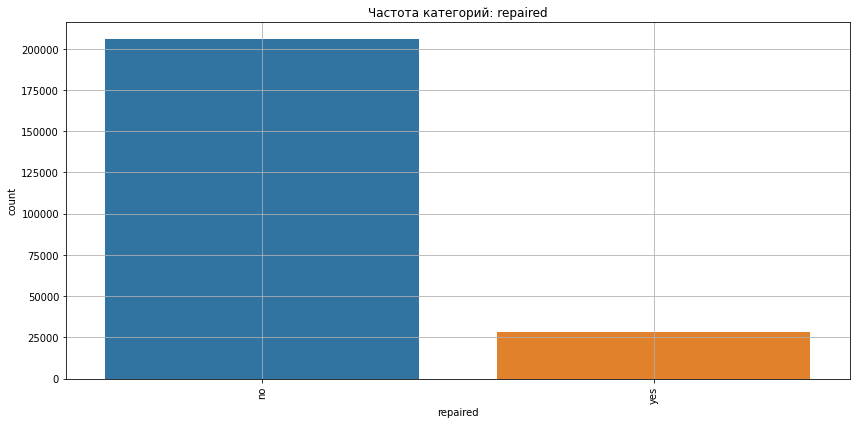

In [34]:
cat_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Частота категорий: {col}')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

1. `brand` - больше всего продают седаны.
2. `gearbox` - МКПП доминирует (понятно, учитывая возраст многих машин).
3. `fuel_type` - абсолютное большинство на бензине.
4. `brand` - самый популярный с большим отрывом *volkswagen*
5. `repaired` - в основном машины не были в ремонте

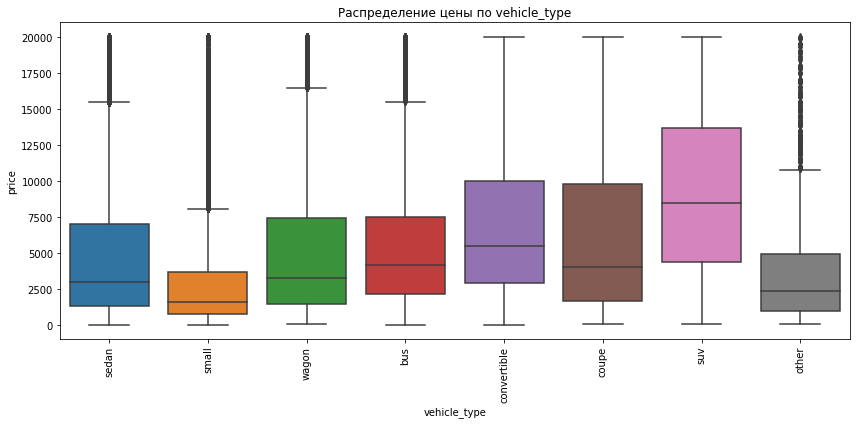

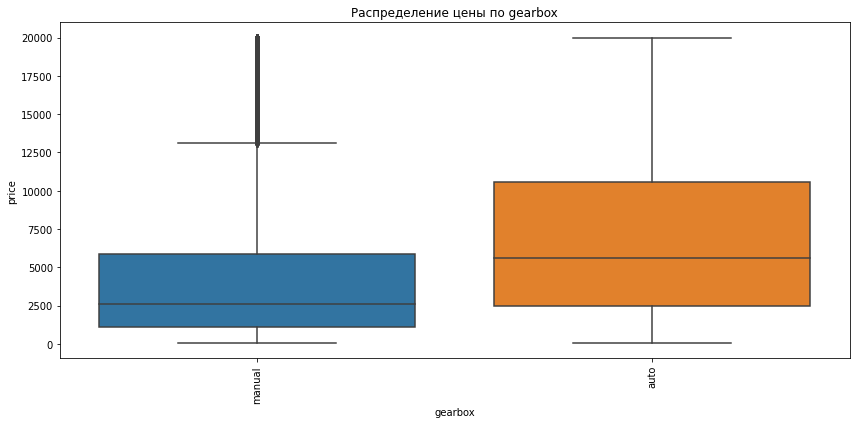

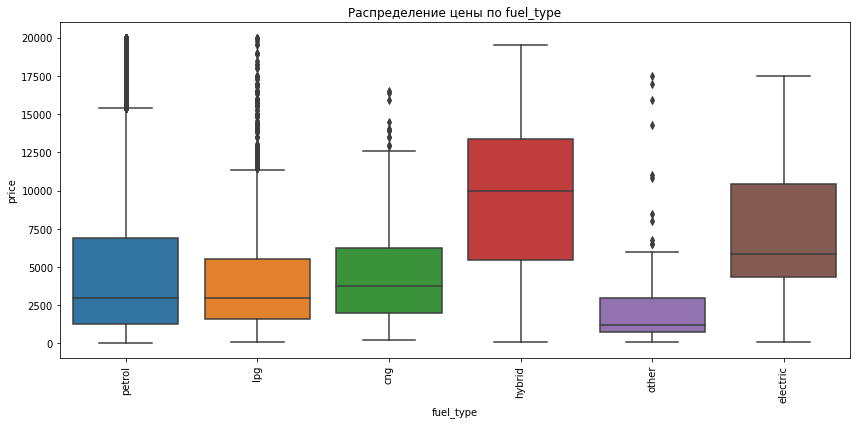

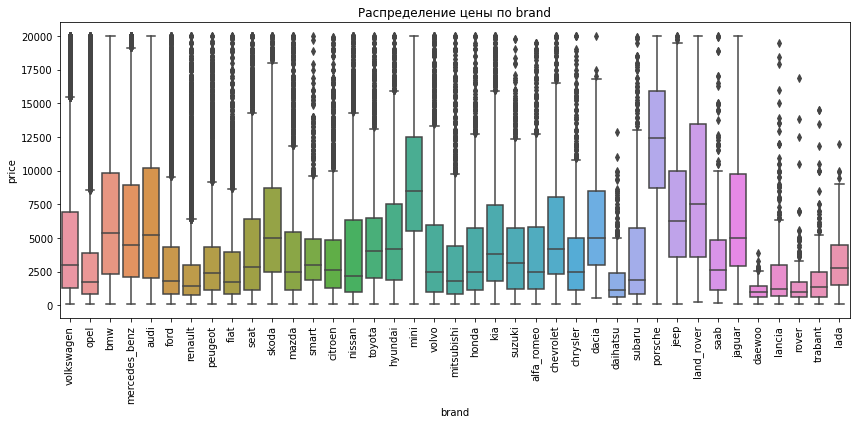

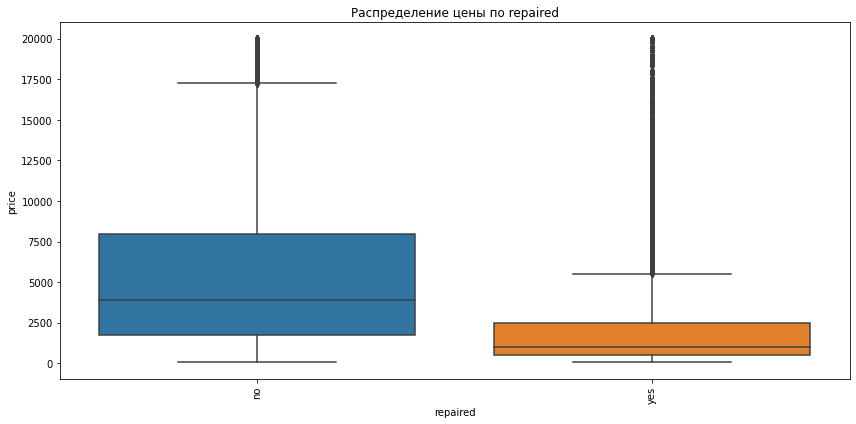

In [35]:
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=col, y='price', order=df[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Распределение цены по {col}')
    plt.tight_layout()
    plt.show()

В более многочисленных категориях больше выбросов.

1. `vehicle_type` - наибольшая медина у категории *suv*. Меньшая - *small*, но там много выбросов 
2. `gearbox` - МКПП имеет медиану меньше, чем АКПП, но много выбросов. Это объяснятся большим количеством предложений по МКПП
3. `fuel_type` - гибриды - самые дорогие
4. `brand` - *porsche* - самый дорогой
5. `repaired` - в этом столбце слишком много пропусков для анализа, но можно сказать, что отремонтированные машины дешевле.

Корреляции:

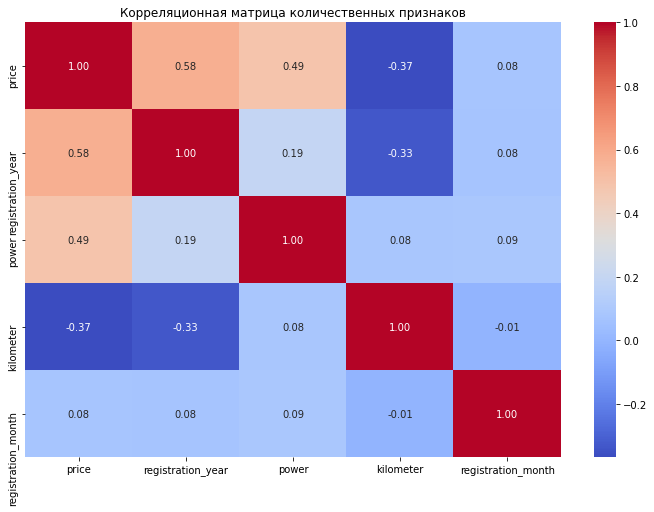

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm",fmt='.2f');
plt.title('Корреляционная матрица количественных признаков')
plt.show()

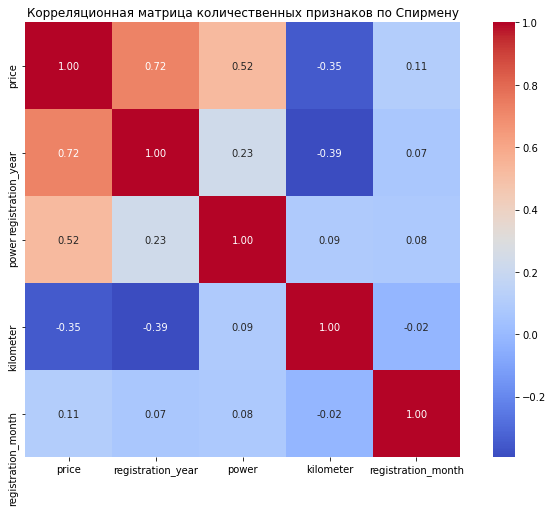

In [37]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap="coolwarm",fmt='.2f', square=True);
plt.title('Корреляционная матрица количественных признаков по Спирмену')
plt.show()

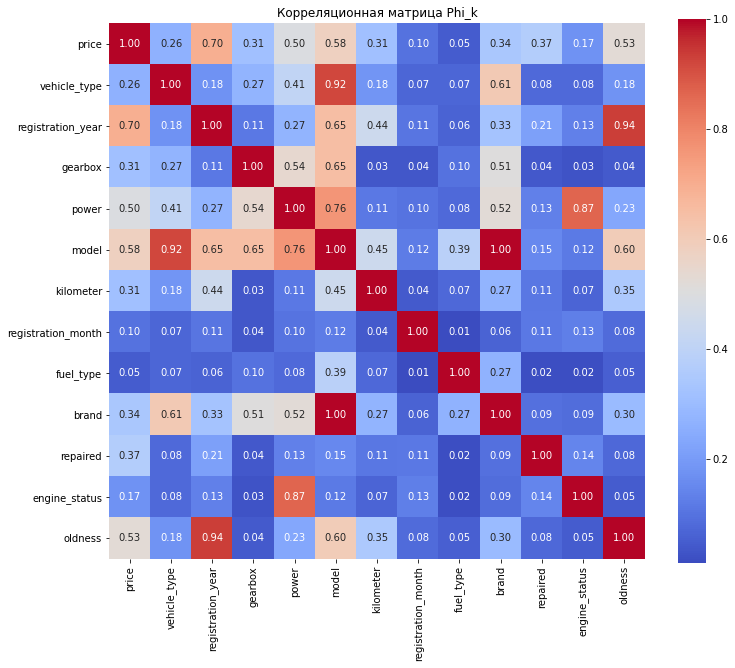

In [38]:
interval_df = df_phik = df.dropna()
interval_cols = interval_df.select_dtypes(include='number').columns.tolist()

phi_k_matrix = interval_df.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(12, 10))
sns.heatmap(phi_k_matrix, annot=True, cmap='coolwarm',fmt='.2f', square=True);
plt.title('Корреляционная матрица Phi_k')
plt.show()

In [39]:
for col in df[['power', 'registration_year']]:
    unique_values = df[col].unique()
    print(f"Уникальные значения в столбце '{col}': {unique_values}")

Уникальные значения в столбце 'power': [  0 163  75  69 102 109 125 101 105 140 115 131 190 136 160 231  50 118
 193  99  60 113 218 122 129  70 306  95  61 177 170 143 232 150 156  80
  82  90 155 185  87 180  86  84 224 235 200 178 265  77 110 144 120  54
 286 116 184 126 204  88 194  64 305 197 179 250 313  41  45 165  98 130
 114 211  56 201 213  58 107 174 100 220  73 192  66 299  74  52 147  71
  97  65 239  68 203 300 103  85 258 320  63  81 148  44  83 145  55 280
 260 104 188 333 117 141 132 234 158  39  92  51 135 230  53 209  43 146
  67 106 166 276 344  72 237 245 111 326 279  23 138 310 175  96 226 301
 334 128 133 124  33 219 241 167 182 196 238 228  48 272 139 186  79 256
 243 252 396 340 121 187 289 222 198 284  37 450 233 112 387 347 172  57
 137  94 212 476 314   7 173 290 207 205 171  78  91  89 349  40 108 325
  76  93 142 343 199 164  16 152  47  59 367 240 208 210  46 435 225 127
  26 176 161 307 354  35 206 355 273 223 255 151  30 123 154 149 268 400
 275  34   2

`model` и `brand`: 0.93 — очевидная связь

`model` и `power`: 0.98 — мощность зависит от модели + это скорее категориальная величина

`vehicle_type` и `model`: 0.92 — у моделей конкретные кузовы.

Признак `model` хоть и выглядит избыточным, но, кажется, его лучше оставить.

In [40]:
df = df.drop('registration_month', axis = 1)

## Обучение моделей

In [41]:
X = df.drop('price', axis = 1)
y = df['price']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25)

In [42]:
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()

In [43]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

#категориальные переменные с OneHotEncoder
cat_pipe_ohe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

#категориальные переменные с TargetEncoder
cat_pipe_te = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('te', TargetEncoder())
])

#препроцессор для линрега
data_preprocessor_ohe = ColumnTransformer([
    ('cat', cat_pipe_ohe, cat_cols),
    ('num', num_pipe, num_cols)
])

#препроцессор для деревьев
data_preprocessor_te = ColumnTransformer([
    ('cat', cat_pipe_te, cat_cols),
    ('num', 'passthrough', num_cols)
])

#пайплайн для линрега
pipe_linear = Pipeline([
    ('preprocessor', data_preprocessor_ohe),
    ('models', LinearRegression())
])

#пайплайн для деревьев
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor_te),
    ('models', CatBoostRegressor(verbose=False, random_state=1))
])


pipe_final = Pipeline([
    ('preprocessor', data_preprocessor_ohe),
    ('models', LinearRegression())
])

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor': [data_preprocessor_ohe],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
        'models': [CatBoostRegressor(verbose=False, random_state=1)],
        'models__depth': [4, 6],
        'models__iterations': [50, 100],
        'preprocessor': [data_preprocessor_te]
    },
    {
        'models': [LGBMRegressor(verbose=-1, random_state=1)],
        'models__num_leaves': [31, 63],
        'models__n_estimators': [50, 100],
        'preprocessor': [data_preprocessor_te]
    }
]
cv = KFold(n_splits=3, shuffle=True, random_state=1)

rand_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    random_state=1,
    n_jobs=-1,
    n_iter = 10,
    refit=False,
    return_train_score=True
    )

In [44]:
%%time

rand_search.fit(X_train, y_train)


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories

CPU times: user 4min 25s, sys: 2min, total: 6min 25s
Wall time: 6min 33s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired',
                                                                                'engin...
                                         'preprocessor': [ColumnTransformer(transformers=[('cat',
                                                                                           Pipeline(steps=[('imputer',
                                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                                           ('te',
                                                                                                            TargetEncoder())]),
                                                                                           ['vehicle_type',
                                                                                            'gearbox',
                                                                                            'model',
                                                                                            'fuel_type',
                                                                                            'brand',
                                                                                            'repaired',
                                                                                            'engine_status',
                                                                                            'oldness']),
                                                                                          ('num',
                                                                                           'passthrough',
                                                                                           ['registration_year',
                                                                                            'power',
                                                                                            'kilometer'])])]}],
                   random_state=1, refit=False, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [45]:
params_df = pd.DataFrame(rand_search.cv_results_).set_index('rank_test_score').sort_index(ascending=True)

display(params_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__scaler,param_preprocessor,param_models,param_models__iterations,param_models__depth,param_models__num_leaves,...,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,6.189159,0.247026,0.769937,0.041775,NaN,"ColumnTransformer(transformers=[('cat',\n ...","LGBMRegressor(random_state=1, verbose=-1)",NaN,NaN,63,...,-1596.751894,-1597.903963,-1598.909499,-1597.855119,0.881516,-1509.301816,-1507.938835,-1505.474167,-1507.571606,1.584060
2,4.330935,0.064114,0.290726,0.007908,NaN,"ColumnTransformer(transformers=[('cat',\n ...",<catboost.core.CatBoostRegressor object at 0x7...,100,6,NaN,...,-1623.716870,-1621.431052,-1623.583127,-1622.910350,1.047446,-1544.663321,-1541.941285,-1544.529011,-1543.711206,1.252723
3,4.812946,0.115066,0.701495,0.002455,NaN,"ColumnTransformer(transformers=[('cat',\n ...","LGBMRegressor(random_state=1, verbose=-1)",NaN,NaN,31,...,-1636.596190,-1634.258401,-1637.381606,-1636.078733,1.326505,-1588.704270,-1585.889549,-1584.072520,-1586.222113,1.905470
4,4.485552,0.139622,0.538763,0.043031,NaN,"ColumnTransformer(transformers=[('cat',\n ...","LGBMRegressor(random_state=1, verbose=-1)",NaN,NaN,63,...,-1643.749118,-1644.512331,-1646.296707,-1644.852719,1.067536,-1591.845214,-1590.952157,-1592.100205,-1591.632526,0.492227
5,4.167779,0.042984,0.275985,0.004621,NaN,"ColumnTransformer(transformers=[('cat',\n ...",<catboost.core.CatBoostRegressor object at 0x7...,100,4,NaN,...,-1668.445080,-1666.107917,-1670.153676,-1668.235558,1.658306,-1628.999892,-1627.562311,-1634.397355,-1630.319853,2.942355
6,3.739300,0.049290,0.565054,0.041297,NaN,"ColumnTransformer(transformers=[('cat',\n ...","LGBMRegressor(random_state=1, verbose=-1)",NaN,NaN,31,...,-1692.338277,-1696.096529,-1697.872037,-1695.435614,2.306979,-1665.540482,-1665.447380,-1666.583282,-1665.857048,0.514930
7,3.481015,0.173317,0.268673,0.007908,NaN,"ColumnTransformer(transformers=[('cat',\n ...",<catboost.core.CatBoostRegressor object at 0x7...,50,4,NaN,...,-1717.277570,-1722.365033,-1724.505934,-1721.382846,3.031593,-1696.832601,-1697.488876,-1705.177219,-1699.832899,3.788491
8,29.457716,0.873665,0.420860,0.006986,RobustScaler(),"ColumnTransformer(transformers=[('cat',\n ...",LinearRegression(),NaN,NaN,NaN,...,-2373.648900,-2357.529518,-2358.227958,-2363.135459,7.439592,-2349.340460,-2357.278577,-2357.139567,-2354.586201,3.709733
9,27.392429,0.893347,0.417734,0.005732,MinMaxScaler(),"ColumnTransformer(transformers=[('cat',\n ...",LinearRegression(),NaN,NaN,NaN,...,-2373.649459,-2357.534422,-2358.225380,-2363.136421,7.439191,-2349.339974,-2357.278172,-2357.139359,-2354.585835,3.709817


Получили список с лучшими моделями. В топ 5 вошли *LGBMR* и *Catboost* Далее обучаем каждую отдельно по подобранным гиперпараметрам. Линейная регрессия не прошла по условию *RMSE* < 2500.

## Анализ моделей

Напишем функции для расчета лучших моделей. 

In [46]:
def catboost_manual(depth, iterations, X_train, y_train, X_val, y_val, cat_cols, num_cols, res_df=None):
    
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('te', TargetEncoder())
    ])

    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, cat_cols),
        ('num', 'passthrough', num_cols)
    ])
    
    model = CatBoostRegressor(
        depth=depth,
        iterations=iterations,
        verbose=False,
        random_state=1
    )
    
    final_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    start_train = time.time()
    final_pipe.fit(X_train, y_train)
    train_time = time.time() - start_train
    
    start_predict = time.time()
    y_pred = final_pipe.predict(X_val)
    predict_time = time.time() - start_predict
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    new_row = pd.DataFrame([{
        'model': 'CatBoostRegressor',
        'depth/num_leaves': depth,
        'iterations': iterations,
        'rmse': rmse,
        'train_time_sec': train_time,
        'predict_time_sec': predict_time,
    }])
    
    if res_df is not None:
        return (pd.concat([res_df, new_row], ignore_index=True), final_pipe)
    return (new_row, final_pipe)

In [47]:
def LightGBM_manual(num_leaves, n_estimators, X_train, y_train, X_val, y_val, cat_cols, num_cols,  res_df=None):
    
    num_pipe = Pipeline([
        ('scaler', StandardScaler())
    ])

    
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('te', TargetEncoder())
    ])

    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ])
    
    model = LGBMRegressor(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        verbose=0,
        random_state=1
    )
    
    final_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    start_train = time.time()
    final_pipe.fit(X_train, y_train)
    train_time = time.time() - start_train
    
    start_predict = time.time()
    y_pred = final_pipe.predict(X_val)
    predict_time = time.time() - start_predict
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    new_row = pd.DataFrame([{
        'model': 'LGBMRegressor',
        'depth/num_leaves': num_leaves,
        'iterations': n_estimators,
        'rmse': rmse,
        'train_time_sec': train_time,
        'predict_time_sec': predict_time,
    }])    
    
    if res_df is not None:
        return (pd.concat([res_df, new_row], ignore_index=True), final_pipe)
    return (new_row, final_pipe)

Выбираем гиперпараметры:

In [48]:
params_df.iloc[4]['params']

{'preprocessor': ColumnTransformer(transformers=[('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('te', TargetEncoder())]),
                                  ['vehicle_type', 'gearbox', 'model',
                                   'fuel_type', 'brand', 'repaired',
                                   'engine_status', 'oldness']),
                                 ('num', 'passthrough',
                                  ['registration_year', 'power', 'kilometer'])]),
 'models__iterations': 100,
 'models__depth': 4,
 'models': <catboost.core.CatBoostRegressor at 0x7fcbb4cfcf70>}

Заново обучаем модели. Возьмем две каждого типа:

In [49]:
results_df = None

results_df, lgbm63100 = LightGBM_manual(
    num_leaves=63,
    n_estimators=100,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    cat_cols=cat_cols,
    num_cols=num_cols,
    res_df=results_df 
)

results_df, catboost6100 = catboost_manual(
    depth=6,
    iterations=100,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    cat_cols=cat_cols,
    num_cols=num_cols,
    res_df=results_df  
)

results_df, lgbm31100 = LightGBM_manual(
    num_leaves=31,
    n_estimators=100,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    cat_cols=cat_cols,
    num_cols=num_cols,
    res_df=results_df 
)

results_df, catboost4100 = catboost_manual(
    depth=4,
    iterations=100,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    cat_cols=cat_cols,
    num_cols=num_cols,
    res_df=results_df  
)


display(results_df)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


,model,depth/num_leaves,iterations,rmse,train_time_sec,predict_time_sec
0,LGBMRegressor,63,100,1587.950164,8.929570,0.715070
1,CatBoostRegressor,6,100,1615.135457,5.804262,0.256212
2,LGBMRegressor,31,100,1631.179608,6.537189,0.704689
3,CatBoostRegressor,4,100,1660.589637,5.631449,0.245626


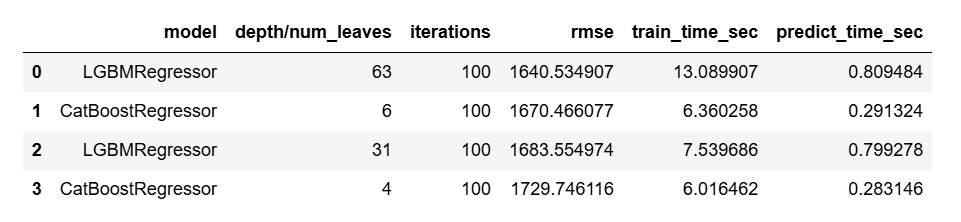

В данном случае *CatBoostRegressor* чуть хуже по метрике rmse (на 1.8% хуже), но обучается в 2 раза быстрее и в 2.7 раз быстрее предсказывает. Если для заказчика важен баланс этих параметров, то надо выбирать CatBoost6100.

Проверим модель:

In [50]:
start_predict = time.time()
y_test_pred = catboost6100.predict(X_test)
predict_time = time.time() - start_predict

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Время предсказывания: {predict_time:.2f}')

Test RMSE: 1620.97
Время предсказывания: 0.28


Дамми модель:

In [51]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(X_train, y_train)

DummyRegressor()

dum_pred = dummy_regr.predict(X_test)
rmse_dummy = mean_squared_error(y_test, dum_pred, squared=False)

print(f'Метрика RMSE на dummy модели: {rmse_dummy:.2f}')
print(f'Метрика RMSE на тестовой выборке: {test_rmse:.2f}')

Метрика RMSE на dummy модели: 4589.13
Метрика RMSE на тестовой выборке: 1620.97


Сравнение обученной модели с дамми моделью показало, что наша модель чему-то научилась.

*SHAP*:

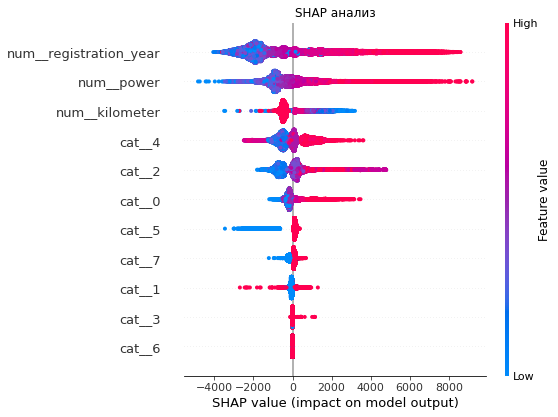

In [52]:
preprocessor = catboost6100.named_steps['preprocessor']
model = catboost6100.named_steps['model']
    
X_transformed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_transformed)
    
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
plt.title(f'SHAP анализ')
plt.tight_layout()
plt.show()

1. `num__registration_year` Чем старше машина, тем она дешевле.

2. `num__power` Чем мощнее машина, тем дороже стоит

3. `num__kilometer` Точки находятся ближе к центру, низкие значения признака слабо влияют на модель

## Выводы

1. В данных есть пропуски и ошибки. Названия столбцов надо привести к принятому виду. Всего 354369 строк.<br><br><br>
2. Осталось 297870 строк. <br>
   Удалено 56499 строк. <br>
   Удалено 15.94% изначальных строк. <br>  

   Обработаны пропуски в столбцах `vehicle_type`, `gearbox`, `fuel_type`. Устранены выбросы в некоторых числовых признаках.
   Все заполненные пропуски заполнены с помощью группировки по моде. Такую группировку я делаю из-за того, что заполняемые значения с большой вероятностью зависят только от сгруппированных признаков. (можно было бы еще смотреть по году регистрации и сравнивать с годами выпуска для столбца `model`, но это опять же неразумно). Признак `repaired` я заполню в *SimpleImputer*, поскольку он будет учитывать все признаки, например, год регистрации и цену, что повысит вероятность заполнить эти пропуски правильно.
   
   Создан столбец `oldness` для группировки машин по возрасту.<br><br><br>
   
3. Анализ данных:<br>
   Гистограммы с ядерной плотностью:
   1. `price` - много выбросов по верхней границе. Медиана около 2500. Скорее всего люксовые машины.
   2. `registration_year` - есть группа очень старых машин.
   3. `kilometer` - значения в основном близки к 125 000–150 000. Есть группа относительно новых машин.
   4. `registration_month` - без сюрпризов. Признак можно удалить как бесполезный. <br><br>
   Боксплоты числовых признаков:
   1. `price` - много выбросов по верхней границе. Медиана около 2500. Скорее всего люксовые машины.
   2. `registration_year` - есть группа очень старых машин.
   3. `kilometer` - значения в основном близки к 125 000–150 000. Есть группа относительно новых машин.
   4. `registration_month` - без сюрпризов. Признак можно удалить как бесполезный. <br><br>
   Частота категорий:
   1. `brand` - больше всего продают седаны.
   2. `gearbox` - МКПП доминирует (понятно, учитывая возраст многих машин).
   3. `fuel_type` - абсолютное большинство на бензине.
   4. `brand` - самый популярный с большим отрывом *volkswagen*
   5. `repaired` - в основном машины не были в ремонте. <br><br>
   Боксплот категориальных признаков по цене:
   1. `vehicle_type` - наибольшая медина у категории *suv*. Меньшая - *small*, но там много выбросов 
   2. `gearbox` - МКПП имеет медиану меньше, чем АКПП, но много выбросов. Это объяснятся большим количеством предложений по МКПП
   3. `fuel_type` - гибриды - самые дорогие
   4. `brand` - *porsche* - самый дорогой
   5. `repaired` - в этом столбце слишком много пропусков для анализа, но можно сказать, что отремонтированные машины дешевле. <br><br>
   Корреляции:
   1. `model` и `brand`: 0.93 — очевидная связь
   2. `model` и `power`: 0.98 — мощность зависит от модели + это скорее категориальная величина
   3. `vehicle_type` и `model`: 0.92 — у моделей конкретные кузовы.<br><br><br>
   
4. В топ-5 лучших моделей вошли три *LGBM* и один *CatBoost*<br><br><br>
   
5. В данном случае *CatBoostRegressor* чуть хуже по метрике rmse (на 1.8% хуже), но обучается в 2 раза быстрее и в 2.7 раз быстрее предсказывает.. Если для заказчика важен баланс этих параметров, то надо выбирать *CatBoost*(*depth*=6, *iterations* = 100).<br><br><br>
6. *SHAP* анализ:<br> 

    `num__registration_year`: Чем старше машина, тем она дешевле.<br>
    `num__power`: Чем мощнее машина, тем дороже стоит<br>
    `num__kilometer`: Точки находятся ближе к центру, низкие значения признака слабо влияют на модель<br>